In [1]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import glob
import lmfit
from py_unsio import *
import wkbl.astro.nbody_essentials as nbe
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import hast
import cfalcon
CF =cfalcon.CFalcon()

### using   /home/arturo/Documents/Dark-Matter-in-the-Sun/notebooks/input.dm  as inputs


In [2]:
def __halo_list_tracking(output):

        list = glob.glob(output+'/clump_?????.txt?????')
        i=0
        for file in list:
                data = np.loadtxt(file,skiprows=1,dtype=None)
                if(np.size(data)==0):
                        continue
                if(i>0):
                        data_all = np.vstack((data_all,data))
                else:
                        data_all = data
                i=i+1
        data_sorted = data_all[data_all[:,3].argsort()]
        data_sorted = data_sorted[::-1]
        return data_sorted


In [3]:
def all_inside(center, r_search):
    try:
        tree = KDTree(np.squeeze(pos3d))
        in_halo = tree.query_radius(center,r_search)[0]
        pos_halo = pos3d[in_halo]
        m_in_halo = mass[in_halo]
    except:
        print "nope"
        sys.exit()
    return pos_halo, m_in_halo
#

In [17]:
path = "/data/MIB/anunez/NewSchool/Mochima/box_4zoom_mochima_halo3_hydro_SF_LR/output_00041"
path = "/data/Mochima5/lowres/output_00041"
#path = "/data/POL/Halo24/Zoom4-Halo24-refmap128-HydroRun/myhalo-out417-st.age.dens"
#center = np.array([7835.1870117, 13770.62597656,12190.21191406])
#center = np.array([0, 0,0])

#path = "/data/MIB/anunez/NewSchool/Mochima/box_4zoom_mochima_halo5_hydro_SF_LR/output_00041/"
#center = np.array([ 9398.61842885,13623.99591716,13770.32966676])

path = "/data/MIB/anunez/NewSchool/Cuba/box25Mpc_zoom_cuba_halo1_hydro_LR/output_00041/"
center = np.array([ 13196.97363281, 15107.32519531, 8205.07519531])
uns = CunsIn(path,"all","all",False)
if uns.isValid()==True:
    print "good"

good


In [18]:
p = nbe.Info_sniffer(path)
ok=uns.nextFrame("")
ok,mass = uns.getArrayF("all","mass")
print ok
ok,pos = uns.getArrayF("all","pos")
pos = pos * p.simutokpc
mass = mass * p.simutoMsun
print ok
pos3d = pos.reshape(len(pos)/3, 3)



True
True


In [19]:
pos_halo, m_in_halo = all_inside(center, 25.)
pos_halo = pos_halo - center
center = center - center
print "there are ",len(pos_halo)," particles in this region"

there are  4971388  particles in this region


In [20]:
pos2 = pos_halo.reshape(len(pos_halo)*3) 
pos2 = np.array(pos2,dtype=np.float32)
ok,rho,_= CF.getDensity(pos2, m_in_halo)
print ok

True


In [8]:
#pos_out = pos_halo.reshape(len(pos_halo)*3).astype(np.float32, copy=False)

In [7]:
#center = pos_halo[(rho==np.max(rho))]
#print center#p.simutokpc


In [8]:
%%latex
here we define the position tensor $\sigma_{ij}$
\begin{equation}
\sigma_{ij} = \left<x_i x_j\right> - \left< x_i \right>\left< x_j \right>
\end{equation}

then we diagonalize it obtaining the  transformation matrix $T$ 
\begin{equation}
T = \left\{ e_1, e_2, e_3 \right\}^T
\end{equation}
where $e_i$ are the column eigen vectors of $\sigma_{ij}$ corresponding to the sorted eigen values $\lambda_i $in the sense that $\lambda_1\gt\lambda_2\gt\lambda_3$ 

<IPython.core.display.Latex object>

In [21]:

r_check = np.sqrt(pos_halo[:,0]**2 + pos_halo[:,1]**2 + pos_halo[:,2]**2 )
print len(r_check)
pos_ring = pos_halo[(r_check<15.)&(r_check>5.)]
print len(pos_ring)
P = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        first = np.average(pos_ring[:,i]*pos_ring[:,j])
        second =(np.average(pos_ring[:,i])*np.average(pos_ring[:,j]))
        P[i][j] = first - second 
  

print P

4971388
2637067
[[ 16.75814735  14.01498576   6.01530378]
 [ 14.01498576  34.74386077  -2.41959758]
 [  6.01530378  -2.41959758  41.72923323]]


In [22]:
eigen_values,eigen_vectors = np.linalg.eig(P)
inv = np.linalg.inv(eigen_vectors)
order = np.argsort(abs(eigen_values))

T = np.zeros((3,3))

T[:,0] = eigen_vectors[:,order[2]]
T[:,1] = eigen_vectors[:,order[1]]
T[:,2] = eigen_vectors[:,order[0]]
Tinv =np.linalg.inv(T)
evecT = np.transpose(eigen_vectors)
evec = eigen_vectors
evecinv =np.linalg.inv(evec)

print "\n T^1 P T\n"
print np.array(np.dot(Tinv,np.dot(P,T)),dtype=int)
print "\n evecT P evec\n"
print np.array(np.dot(evecinv,np.dot(P,evec)),dtype=int)
print "\nP . vec_0 /lambda_0\n"
print np.dot(P,eigen_vectors[:,0])/eigen_values[0]
print "\nP . vec_1 /lambda_1\n"
print np.dot(P,eigen_vectors[:,1])/eigen_values[1]
print "\nP . vec_2 /lambda_2\n"
print np.dot(P,eigen_vectors[:,2])/eigen_values[2]
print "\n"
print "     evec0       evec1      evec2"
print T
print "\nortogonality\nevec0 x evec2 = evec1"
print np.cross(T[:,0],T[:,1])

Rz= np.array([[0,-1,0],[1,0,0],[0,0,1]])
Rx= np.array([[1.,0.,0.],[0.,0.,-1.],[0.,1.,0.]])
Ry= np.array([[0,0,1],[0,1,0],[-1,0,0]])






print "\nT=T(transpose)"

#print eigen_vectors
T=np.matrix.transpose(T)
print T 
j = np.zeros((3,3))
j[0],j[1],j[2] = eigen_vectors[:,order[2]],eigen_vectors[:,order[1]],eigen_vectors[:,order[0]]
print j
print "\nTinv"
print np.linalg.inv(T)
print "\nevec"
print evec
print "\n"


print np.dot(T,np.dot(P,evec))


 T^1 P T

[[43  0  0]
 [ 0 41  0]
 [ 0  0  7]]

 evecT P evec

[[ 7  0  0]
 [ 0 43  0]
 [ 0  0 41]]

P . vec_0 /lambda_0

[ 0.86401167 -0.46748587 -0.18692458]

P . vec_1 /lambda_1

[-0.40689782 -0.42971761 -0.80608742]

P . vec_2 /lambda_2

[-0.2965097  -0.77252814  0.56150002]


     evec0       evec1      evec2
[[-0.40689782 -0.2965097   0.86401167]
 [-0.42971761 -0.77252814 -0.46748587]
 [-0.80608742  0.56150002 -0.18692458]]

ortogonality
evec0 x evec2 = evec1
[-0.86401167  0.46748587  0.18692458]

T=T(transpose)
[[-0.40689782 -0.42971761 -0.80608742]
 [-0.2965097  -0.77252814  0.56150002]
 [ 0.86401167 -0.46748587 -0.18692458]]
[[-0.40689782 -0.42971761 -0.80608742]
 [-0.2965097  -0.77252814  0.56150002]
 [ 0.86401167 -0.46748587 -0.18692458]]

Tinv
[[-0.40689782 -0.2965097   0.86401167]
 [-0.42971761 -0.77252814 -0.46748587]
 [-0.80608742  0.56150002 -0.18692458]]

evec
[[ 0.86401167 -0.40689782 -0.2965097 ]
 [-0.46748587 -0.42971761 -0.77252814]
 [-0.18692458 -0.80608742  0.56

In [13]:
#if sum(np.array(np.cross(T[:,0],T[:,1])-T[:,2],dtype=int))==0:
I = np.array([[1,0,0],[0,1,0],[0,0,1]])


In [23]:
rot = np.zeros((len(pos_halo),3))
print rot
#T = np.array([[1.985941e-01,3.302704e-01,9.227577e-01],[3.602046e-01,-9.002138e-01,2.446790e-01],[ 9.114894e-01,2.837898e-01,-2.977420e-01]])
#T = evecT
rot[:,0] = T[0][0]*pos_halo[:,0] + T[0][1]*pos_halo[:,1] + T[0][2]*pos_halo[:,2]
rot[:,1] = T[1][0]*pos_halo[:,0] + T[1][1]*pos_halo[:,1] + T[1][2]*pos_halo[:,2]
rot[:,2] = T[2][0]*pos_halo[:,0] + T[2][1]*pos_halo[:,1] + T[2][2]*pos_halo[:,2]


print rot[:,0]

#rot[:,0] = T[0][0]*pos_halo[:,0] + T[1][0]*pos_halo[:,1] + T[2][0]*pos_halo[:,2]
#rot[:,1] = T[0][1]*pos_halo[:,0] + T[1][1]*pos_halo[:,1] + T[2][0]*pos_halo[:,2]
#rot[:,2] = T[0][2]*pos_halo[:,0] + T[1][2]*pos_halo[:,1] + T[2][0]*pos_halo[:,2]


[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 ..., 
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[ 23.01743217  23.05967665  23.1535574  ..., -19.02212011 -19.34202086
 -19.17008088]


In [24]:
print center #/ p.simutokpc
half_thicknes = .4
nurot = pos_halo[(abs(pos_halo[:,2]-center[2])<half_thicknes)]
nu_rho = rho[(abs(pos_halo[:,2]-center[2])<half_thicknes)]

nurot2 = pos_halo[(abs(pos_halo[:,1]-center[1])<half_thicknes)]
nu_rho2 = rho[(abs(pos_halo[:,1]-center[1])<half_thicknes)]

nurot3 = pos_halo[(abs(pos_halo[:,0]-center[0])<half_thicknes)]
nu_rho3 = rho[(abs(pos_halo[:,0]-center[0])<half_thicknes)]



[ 0.  0.  0.]


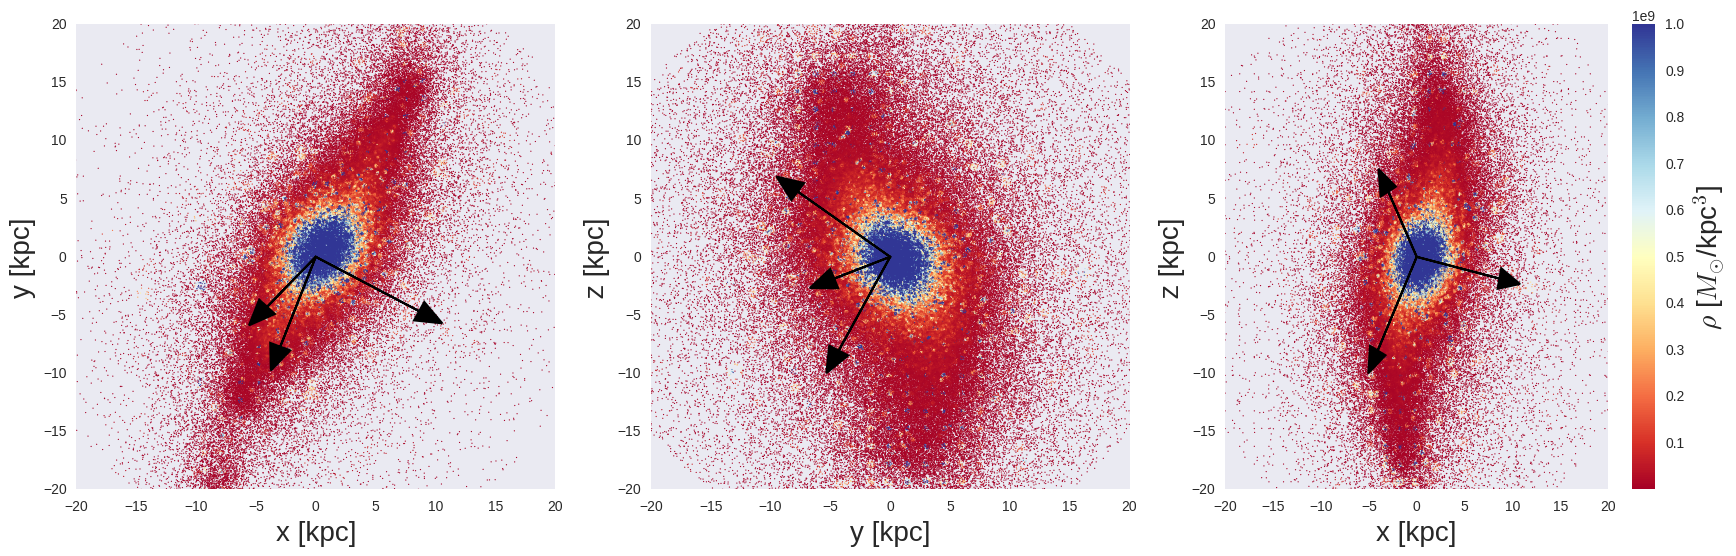

In [25]:
r_search=20.
fig, [ax,ax3,ax2] = plt.subplots(1,3,figsize=[21,6])
ax.set_xlim([center[0]-r_search, center[0]+r_search])
ax.set_ylim([center[1]-r_search, center[1]+r_search])
ax3.set_ylim([center[1]-r_search, center[1]+r_search])
ax3.set_xlim([center[2]-r_search, center[2]+r_search])

ax2.set_xlim([center[0]-r_search, center[0]+r_search])
ax2.set_ylim([center[2]-r_search, center[2]+r_search])

cm = plt.cm.get_cmap('RdYlBu')
ax.grid(which='both')
ax2.grid(which='both')
ax3.grid(which='both')
ax.set_xlabel("x [kpc]",fontsize=20)
ax2.set_xlabel("x [kpc]",fontsize=20)
ax3.set_xlabel("y [kpc]",fontsize=20)
ax.set_ylabel("y [kpc]",fontsize=20)
ax2.set_ylabel("z [kpc]",fontsize=20)
ax3.set_ylabel("z [kpc]",fontsize=20)
scale=10
i,j = 0,1
ax.arrow(0, 0, scale*evec[i][0], scale*evec[j][0], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
ax.arrow(0, 0, scale*evec[i][1], scale*evec[j][1], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
ax.arrow(0, 0, scale*evec[i][2], scale*evec[j][2], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')

i,j = 1,2
ax3.arrow(0, 0, scale*evec[i][0], scale*evec[j][0], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
ax3.arrow(0, 0, scale*evec[i][1], scale*evec[j][1], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
ax3.arrow(0, 0, scale*evec[i][2], scale*evec[j][2], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')

i,j = 0,2
ax2.arrow(0, 0, scale*evec[i][0], scale*evec[j][0], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
ax2.arrow(0, 0, scale*evec[i][1], scale*evec[j][1], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
ax2.arrow(0, 0, scale*evec[i][2], scale*evec[j][2], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')





ax.scatter(nurot[:,0], nurot[:,1], c=nu_rho, cmap=cm,vmin=1e4, vmax=1e9,lw=0, s=0.8)#nu_rho)
ax3.scatter(nurot3[:,1], nurot3[:,2], c=nu_rho3, cmap=cm,vmin=1e4, vmax=1e9,lw=0, s=0.8)#nu_rho)
coco =ax2.scatter(nurot2[:,0], nurot2[:,2], c=nu_rho2, cmap=cm,vmin=1e4, vmax=1e9,lw=0, s=0.8)
cbar = plt.colorbar(coco)#,orientation='horizontal')
cbar.set_label(r'$\rho$ [$M_{\odot}$/kpc$^3$]',fontsize=20)
#ax.scatter(rot[:,0],pos_halo[:,1],s=0.01)
#ax.scatter(list_pos[:,0],list_pos[:,1],s=1.1, c='r',lw=0)

In [26]:
print center #/ p.simutokpc
half_thicknes = .1
nurot = rot[(abs(rot[:,2]-center[2])<half_thicknes)]
nu_rho = rho[(abs(rot[:,2]-center[2])<half_thicknes)]

nurot2 = rot[(abs(rot[:,1]-center[1])<half_thicknes)]
nu_rho2 = rho[(abs(rot[:,1]-center[1])<half_thicknes)]

nurot3 = rot[(abs(rot[:,0]-center[0])<half_thicknes)]
nu_rho3 = rho[(abs(rot[:,0]-center[0])<half_thicknes)]



[ 0.  0.  0.]


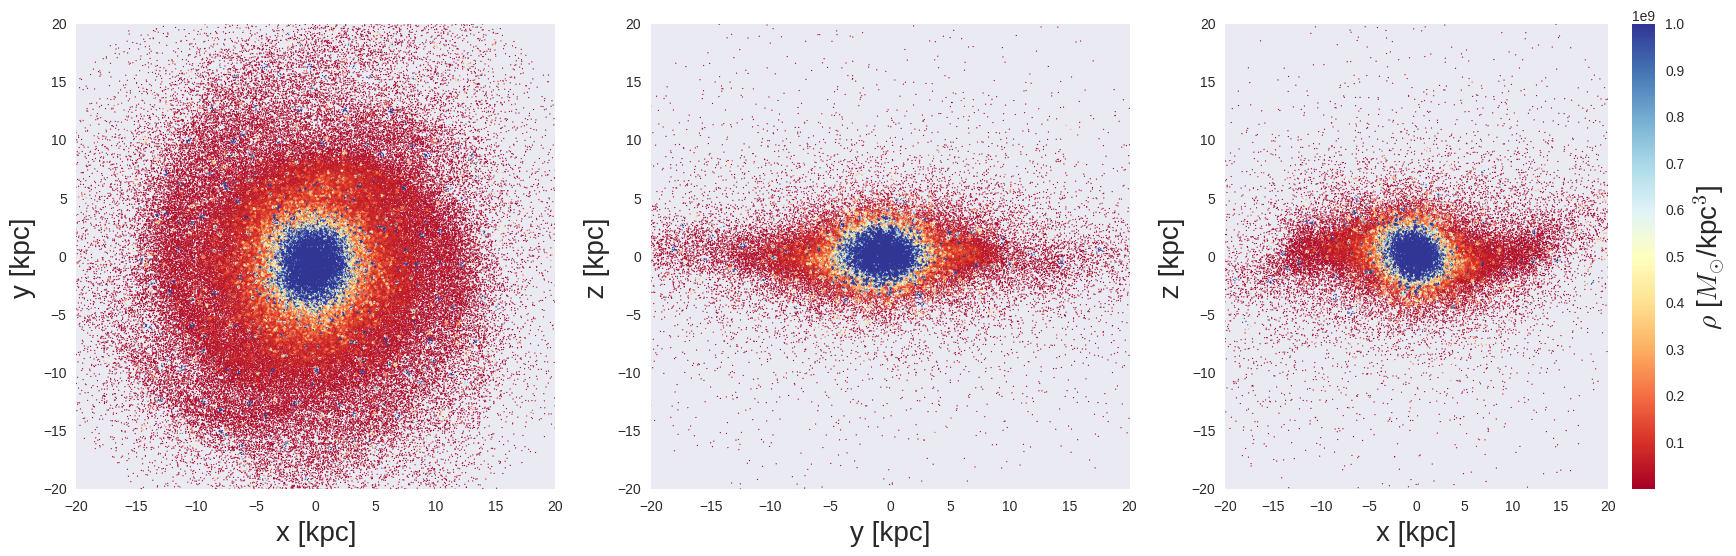

In [27]:
r_search=20.
fig, [ax,ax3,ax2] = plt.subplots(1,3,figsize=[21,6])
ax.set_xlim([center[0]-r_search, center[0]+r_search])
ax.set_ylim([center[1]-r_search, center[1]+r_search])
ax3.set_ylim([center[1]-r_search, center[1]+r_search])
ax3.set_xlim([center[2]-r_search, center[2]+r_search])

ax2.set_xlim([center[0]-r_search, center[0]+r_search])
ax2.set_ylim([center[2]-r_search, center[2]+r_search])

cm = plt.cm.get_cmap('RdYlBu')
ax.grid(which='both')
ax2.grid(which='both')
ax3.grid(which='both')
ax.set_xlabel("x [kpc]",fontsize=20)
ax2.set_xlabel("x [kpc]",fontsize=20)
ax3.set_xlabel("y [kpc]",fontsize=20)
ax.set_ylabel("y [kpc]",fontsize=20)
ax2.set_ylabel("z [kpc]",fontsize=20)
ax3.set_ylabel("z [kpc]",fontsize=20)

i,j = 0,1
#ax.arrow(0, 0, scale*evec[i][0], scale*evec[j][0], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
#ax.arrow(0, 0, scale*evec[i][1], scale*evec[j][1], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
#ax.arrow(0, 0, scale*evec[i][2], scale*evec[j][2], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')

i,j = 1,2
#ax3.arrow(0, 0, scale*evec[i][0], scale*evec[j][0], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
#ax3.arrow(0, 0, scale*evec[i][1], scale*evec[j][1], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
#ax3.arrow(0, 0, scale*evec[i][2], scale*evec[j][2], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')

i,j = 0,2
#ax2.arrow(0, 0, scale*evec[i][0], scale*evec[j][0], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
#ax2.arrow(0, 0, scale*evec[i][1], scale*evec[j][1], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')
#ax2.arrow(0, 0, scale*evec[i][2], scale*evec[j][2], lw =1.5,head_width=1.8, head_length=2.2, fc='k', ec='k')





ax.scatter(nurot[:,0], nurot[:,1], c=nu_rho, cmap=cm,vmin=1e4, vmax=1e9,lw=0, s=0.8)#nu_rho)
ax3.scatter(nurot3[:,1], nurot3[:,2], c=nu_rho3, cmap=cm,vmin=1e4, vmax=1e9,lw=0, s=0.8)#nu_rho)
coco =ax2.scatter(nurot2[:,0], nurot2[:,2], c=nu_rho2, cmap=cm,vmin=1e4, vmax=1e9,lw=0, s=0.8)
cbar = plt.colorbar(coco)#,orientation='horizontal')
cbar.set_label(r'$\rho$ [$M_{\odot}$/kpc$^3$]',fontsize=20)
#ax.scatter(rot[:,0],pos_halo[:,1],s=0.01)
#ax.scatter(list_pos[:,0],list_pos[:,1],s=1.1, c='r',lw=0)

In [97]:
pos_halo[0]*T[0]

176.62869974259237

In [15]:
outfile="mysnap.g2"     # output filename
type="nemo"             # we choose to save file in gadget2 format
unsout=CunsOut(outfile,type)  # instantiate output object
#pos_out = rot.reshape(len(rot)*3) / p.simutokpc
pos_out = pos2.astype(np.float32, copy=False)
mass_out = m_in_halo * p.simutoMsun
#rho_out = rho *  [p.simutokpc**3] / p.simutoMsun
mass_out = mass_out.astype(np.float32, copy=False)
comp = "stars"
ok=unsout.setArrayF(comp,"pos",pos_out)
print ok
ok=unsout.setArrayF(comp,"mass",mass_out)
print ok
#ok=unsout.setArrayF(comp,"rho",rho_out)
#print ok

0
0


In [14]:
unsout.save()

1

In [ ]:
#list_ = list[(list[:,10]>1.2e12)&(list[:,10]<2.0e12)]
list_pos = list[:,4:7]
tree = KDTree(np.squeeze(list_pos))
ins = tree.query_radius(center/p.simutokpc,500/p.simutokpc)[0]
list_in = list[ins]
list_in = list[list_in[:,10].argsort()]
center = list_in[0,4:7]*p.simutokpc

In [ ]:
np.array([0.53,0.6,0.33])*p.simutokpc
list = hast.halo_list(path,quiet=True)
